# First training

In [1]:
import sys
import os
current_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
import torch as tr
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split   
import matplotlib.pyplot as plt
from src.dataset import SeqDataset, pad_batch
from src.diffusion import DiffusionModel
from src.layers.simpleunet import SimpleUNet

In [2]:
BATCH_SIZE = 4      
LR = 1e-3           
EPOCHS = 5          
TIMESTEPS = 100     
LAMBDA_VLB = 0.1   # loss VLB hyperparameter
DEVICE = tr.device("cuda" if tr.cuda.is_available() else "cpu")

In [ ]:
DATA_PATH = "../data/ArchiveII_128_random_split/"

TRAIN_PATH = DATA_PATH +  "train.csv"
VAL_PATH = DATA_PATH + "val.csv"

train_dataset = SeqDataset(TRAIN_PATH)
val_dataset = SeqDataset(VAL_PATH) 

# --- DATALOADERS ---
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=pad_batch, 
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=pad_batch,
    num_workers=2
)

START TRAINING...


Epoch 1/5 [Val  ]: 100%|██████████| 87/87 [00:06<00:00, 13.48it/s]


Epoch 1/5 | Train Loss: 0.0176 | Val Loss: 0.0088
   --> SAVING BEST MODEL (Val Loss: 0.0088) 	 epoch: 0


Epoch 2/5 [Val  ]: 100%|██████████| 87/87 [00:06<00:00, 13.24it/s]


Epoch 2/5 | Train Loss: 0.0055 | Val Loss: 0.0038
   --> SAVING BEST MODEL (Val Loss: 0.0038) 	 epoch: 1


Epoch 3/5 [Val  ]: 100%|██████████| 87/87 [00:06<00:00, 13.56it/s]


Epoch 3/5 | Train Loss: 0.0032 | Val Loss: 0.0031
   --> SAVING BEST MODEL (Val Loss: 0.0031) 	 epoch: 2


Epoch 4/5 [Val  ]: 100%|██████████| 87/87 [00:06<00:00, 13.70it/s]


Epoch 4/5 | Train Loss: 0.0023 | Val Loss: 0.0025
   --> SAVING BEST MODEL (Val Loss: 0.0025) 	 epoch: 3


Epoch 5/5 [Val  ]: 100%|██████████| 87/87 [00:06<00:00, 13.62it/s]


Epoch 5/5 | Train Loss: 0.0018 | Val Loss: 0.0020
   --> SAVING BEST MODEL (Val Loss: 0.0020) 	 epoch: 4


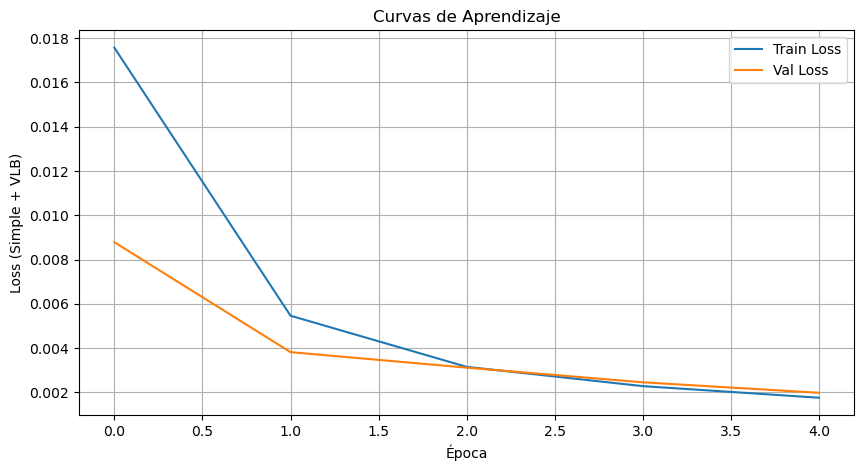

In [4]:
# --- MODEL ---
from tqdm import tqdm
unet = SimpleUNet(in_channels=18, out_channels=2, base_dim=64)
model = DiffusionModel(
    num_classes=2, 
    embedding_dim=64, 
    time_steps=TIMESTEPS, 
    model=lambda **kwargs: unet
)
model.to(DEVICE)

optimizer = tr.optim.Adam(model.parameters(), lr=LR)

# --- HISTORY ---
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
print("START TRAINING...")

for epoch in range(EPOCHS):
    # ==========================
    # 1. training
    # ==========================
    model.train()
    train_loss_accum = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)
    for batch in pbar:
        optimizer.zero_grad()
        
        # Cargar datos
        x0_idx = batch["contact"].to(DEVICE)       # -1 padding
        x0_oh = batch["contact_oh"].to(DEVICE)     # 0.0 padding
        condition = batch["outer"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)            # 1.0 valid, 0.0 padding
        
        # Sample t
        t = tr.randint(0, TIMESTEPS, (x0_idx.shape[0],), device=DEVICE).long()
        
        # noise and Forward
        xt_noisy = model.q_sample(x0_oh, t)
        
        # clean noise on padding
        xt_noisy = xt_noisy * mask.squeeze(1).long()
        
        # predict x0
        logits_pred = model.predict_start(xt_noisy, t, condition, return_logits=True)
        
        # Loss Simple + VLB
        loss_simple = F.cross_entropy(logits_pred, x0_idx, ignore_index=-1)
        loss_vlb = model.compute_vlb(x0_oh, xt_noisy, t, condition, mask=mask)
        loss = loss_simple + (LAMBDA_VLB * loss_vlb)
        
        loss.backward()
        optimizer.step()
        
        train_loss_accum += loss.item()

    avg_train_loss = train_loss_accum / len(train_loader)
    
    # ==========================
    # 2. VALIDATION
    # ==========================
    model.eval() # Dropout and BatchNorm
    val_loss_accum = 0
    
    with tr.no_grad(): 
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val  ]", leave=True)
        for batch in val_pbar:
            x0_idx = batch["contact"].to(DEVICE)
            x0_oh = batch["contact_oh"].to(DEVICE)
            condition = batch["outer"].to(DEVICE)
            mask = batch["mask"].to(DEVICE)
            
            # Same noise to validate the loss
            t = tr.randint(0, TIMESTEPS, (x0_idx.shape[0],), device=DEVICE).long()
            xt_noisy = model.q_sample(x0_oh, t)
            xt_noisy = xt_noisy * mask.squeeze(1).long()
            
            logits_pred = model.predict_start(xt_noisy, t, condition, return_logits=True)
            
            loss_simple = F.cross_entropy(logits_pred, x0_idx, ignore_index=-1)
            loss_vlb = model.compute_vlb(x0_oh, xt_noisy, t, condition, mask=mask)
            
            val_loss = loss_simple + (LAMBDA_VLB * loss_vlb)
            val_loss_accum += val_loss.item()
            
    avg_val_loss = val_loss_accum / len(val_loader)
    
    # ==========================
    # 3. LOGGING AND CHECKPOINT
    # ==========================
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # tr.save(model.state_dict(), "best_model.pt")
        print(f"   --> SAVING BEST MODEL (Val Loss: {avg_val_loss:.4f}) \t epoch: {epoch}")

# ==========================
# 4. PLOT LEARNING CURVES
# ==========================
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Curvas de Aprendizaje')
plt.xlabel('Época')
plt.ylabel('Loss (Simple + VLB)')
plt.legend()
plt.grid(True)
plt.show()

Ploting 10 random structures...


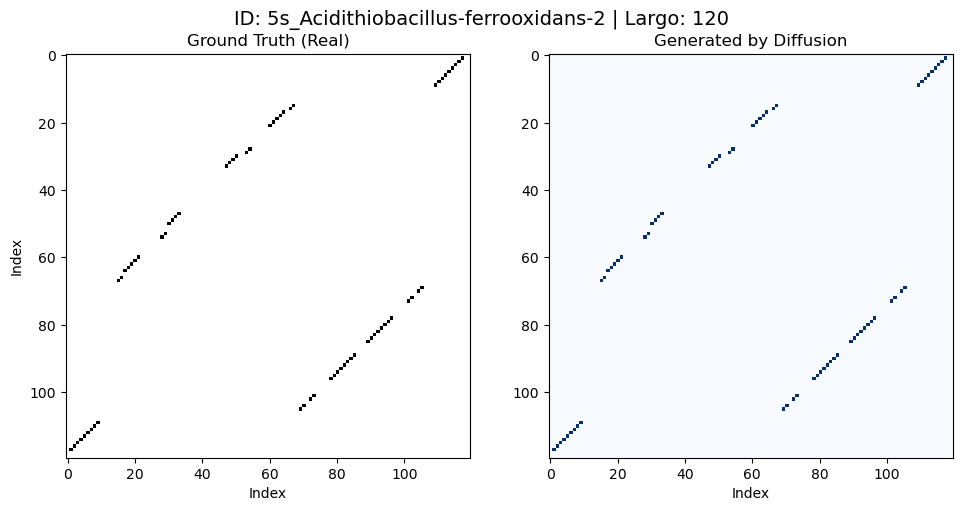

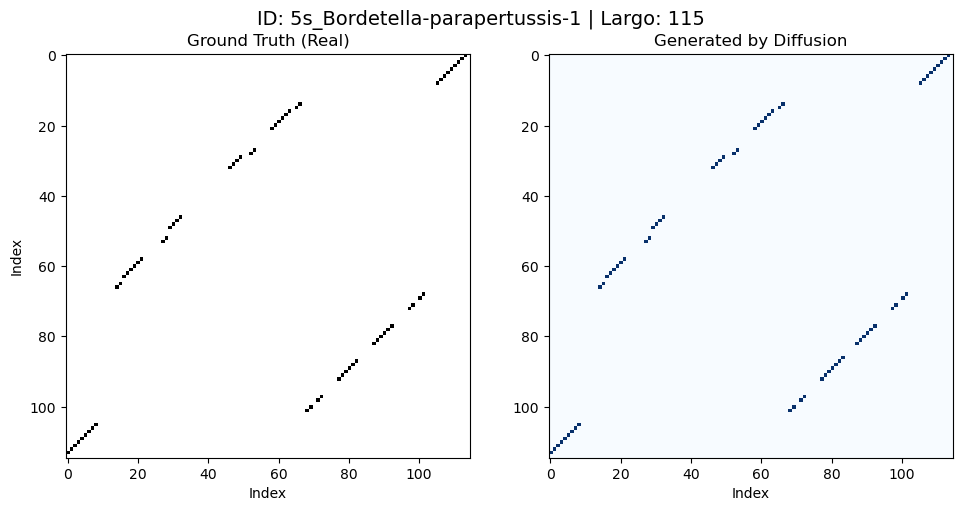

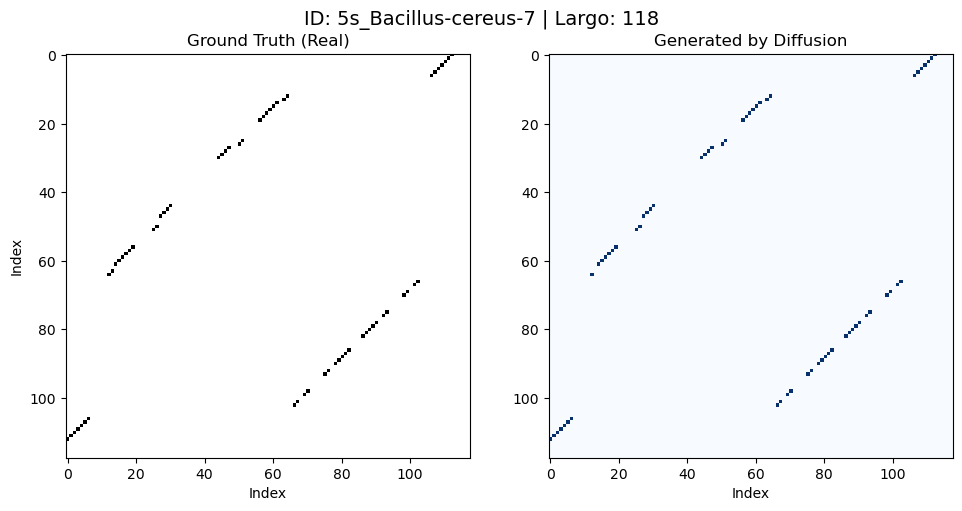

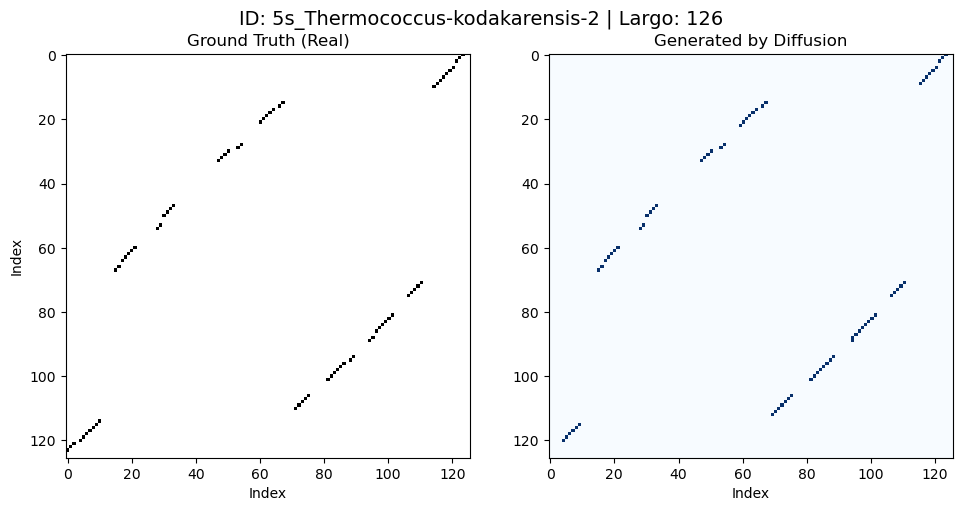

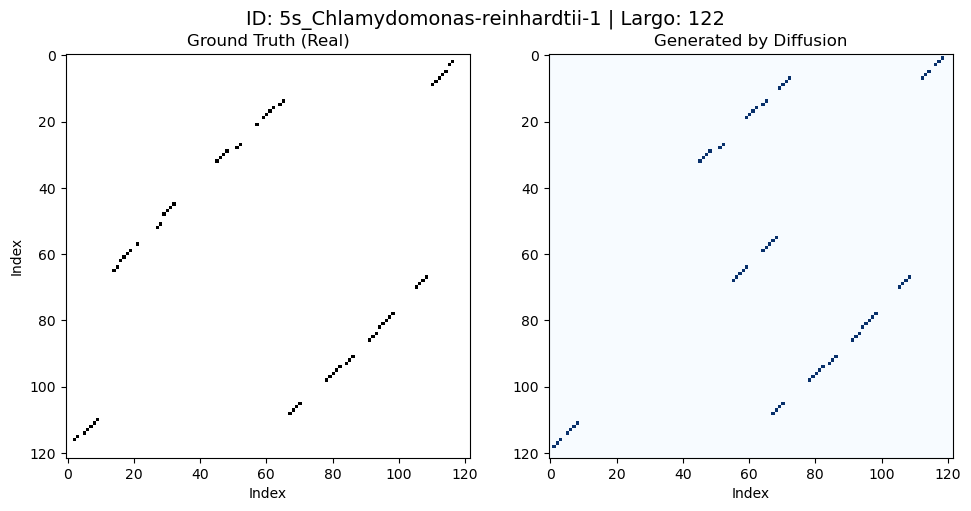

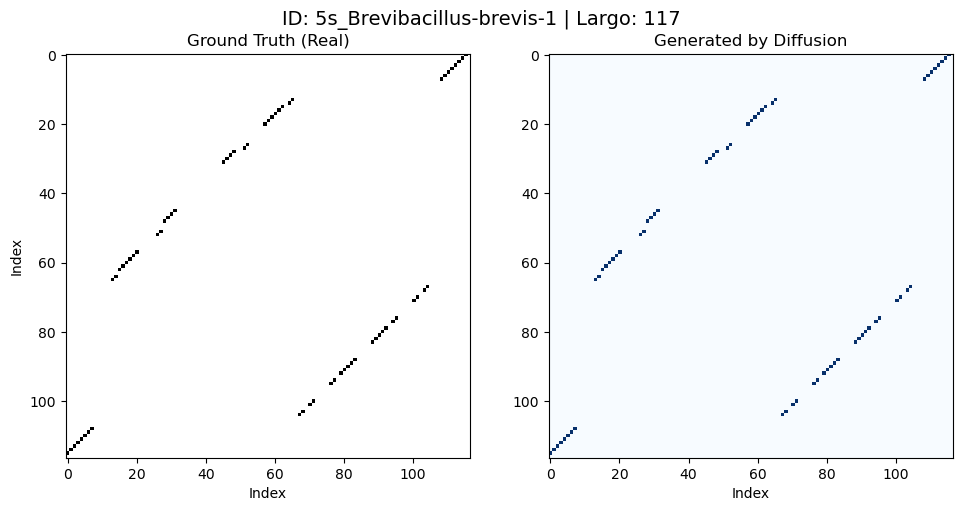

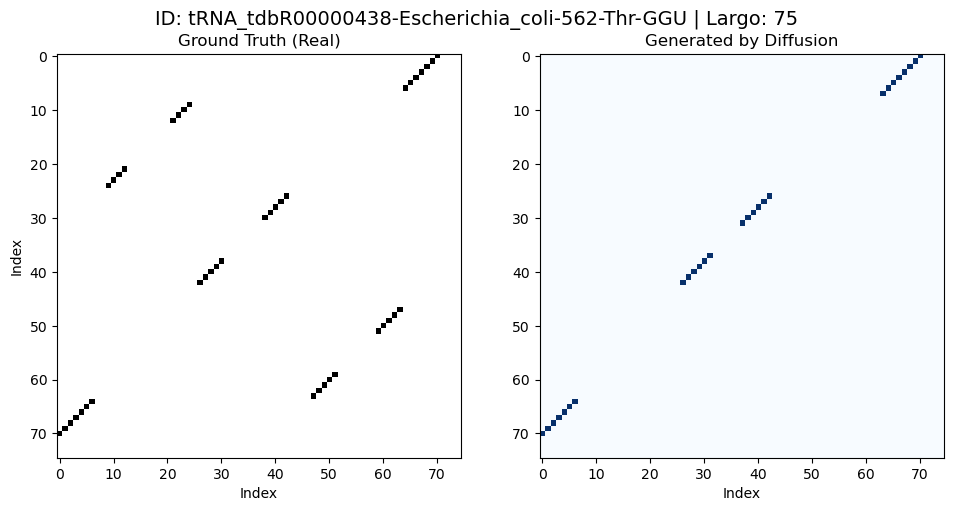

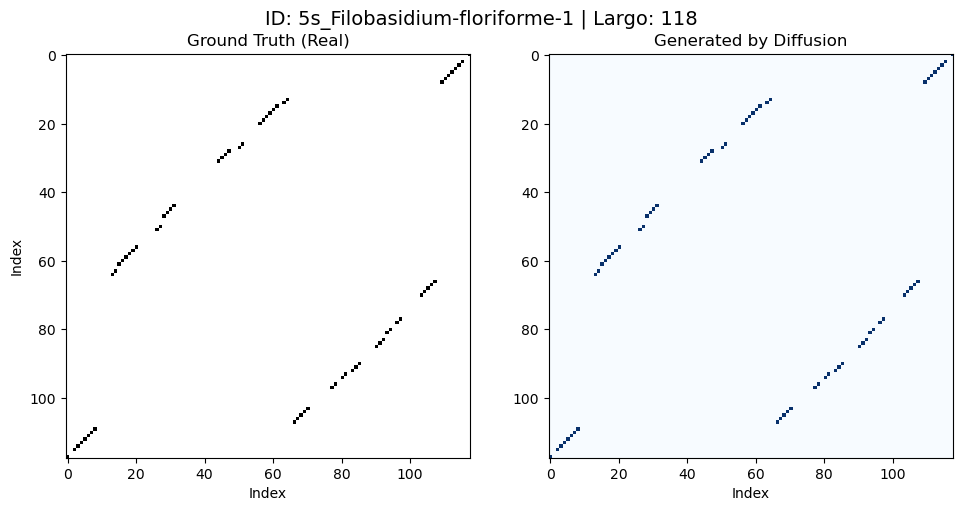

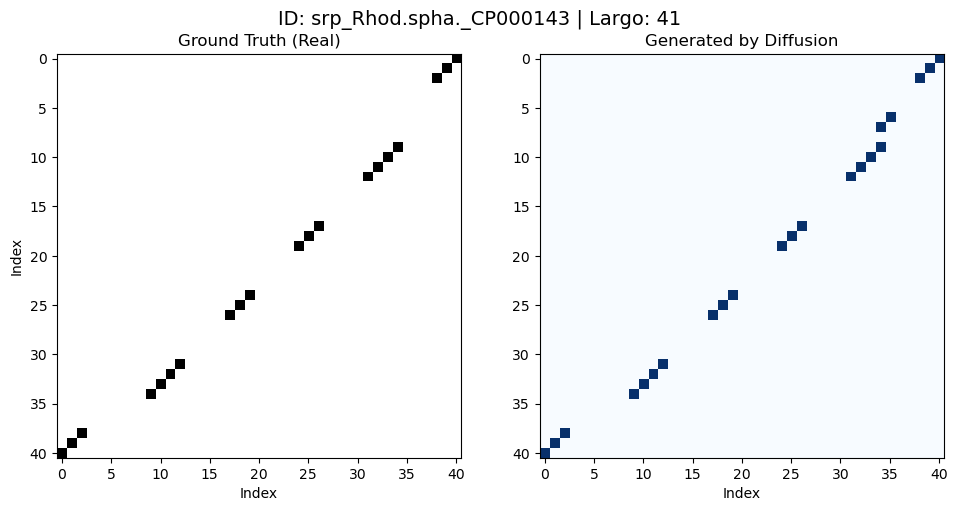

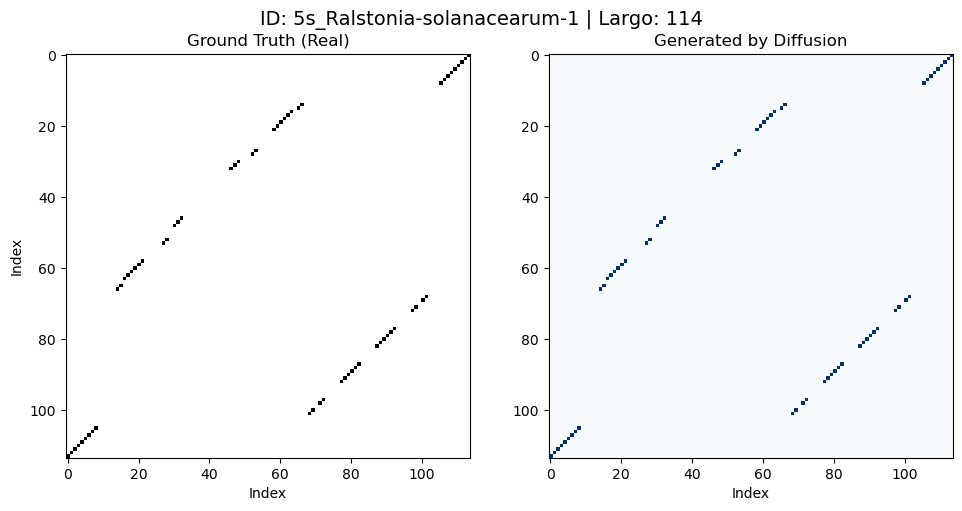

In [6]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(target, prediction, title_str):
    """
    Auxiliar function for plotting a pair: Ground Truth vs Prediction.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # 1. Ground Truth (left)
    # white 0, black 1 (contact)
    im1 = axes[0].imshow(target.cpu(), cmap="Greys", origin="upper", vmin=0, vmax=1)
    axes[0].set_title("Ground Truth (Real)")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel("Index")

    # 2. Generated (right)
    im2 = axes[1].imshow(prediction.cpu(), cmap="Blues", origin="upper", vmin=0, vmax=1)
    axes[1].set_title("Generated by Diffusion")
    axes[1].set_xlabel("Index")
    
    fig.suptitle(title_str, fontsize=14)
    plt.tight_layout()
    plt.show()

def visualize_random_samples(model, dataset, num_samples=10):
    """
    Takes random samples from the dataset, process and plot them.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # random ids
    idxs = random.sample(range(len(dataset)), num_samples)
    
    print(f"Ploting {num_samples} random structures...")
    
    for idx in idxs:
        raw_item = dataset[idx]
        batch_list = [raw_item] # pad_batch expects a list
        # tensors 'outer', 'mask', etc.
        batch = pad_batch(batch_list)
        
        # 3. Move to GPU
        # batch_size=1, dims [1, ...]
        condition = batch["outer"].to(device)
        target_full = batch["contact"].to(device)
        prot_id = batch["id"][0]
        length = batch["length"][0]
        
        # 4. Generate (Sampling)
        #  _sample accept 'condition' and calculates the shape.
        with torch.no_grad():
            # GGenerate from pure noise
            generated_full = model._sample(condition)
            
        #(Remove Padding)
        # Take the first element of the batch [0] and crops to [length, length]
        target_crop = target_full[0, :length, :length]
        generated_crop = generated_full[0, :length, :length]

        # the target has -1, I convert it to 0 for plotting
        target_crop = torch.where(target_crop == -1, torch.tensor(0, device=device), target_crop)

        title = f"ID: {prot_id} | Largo: {length}"
        plot_comparison(target_crop, generated_crop, title)

# --- EXECUTION ---
visualize_random_samples(model, val_dataset, num_samples=10)